# 1. Data Preprocessing & Cleaning

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloaded required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Loads the datasets
x_train = pd.read_csv(r'Dataset/x_train.csv', header=None, names=['website_name', 'text'])
x_test  = pd.read_csv(r'Dataset/x_test.csv',  header=None, names=['website_name', 'text'])
y_train = pd.read_csv(r'Dataset/y_train.csv', header=None, names=['is_positive_sentiment'])
y_test  = pd.read_csv(r'Dataset/y_test.csv',  header=None, names=['is_positive_sentiment'])

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define contractions dictionary
contractions_dict = {
    "can't": "cannot", "won't": "will not", "n't": " not",
    "'re": " are",    "'s": " is",         "'d": " would",
    "'ll": " will",   "'t": " not",        "'ve": " have",
    "'m": " am"
}

# Function to expand contractions
def expand_contractions(text):
    for contr, full in contractions_dict.items():
        text = re.sub(contr, full, text)
    return text

# Definition pf cleaning function
def clean_text(text):
    text = expand_contractions(text)                  # expand contractions
    text = re.sub(r'[^\w\s]', '', text)              # remove punctuation
    text = re.sub(r'\d+', '', text)                  # remove digits
    text = text.lower()                              # lowercase
    tokens = nltk.word_tokenize(text)                # tokenize
    # Remove stopwords but keep negations
    tokens = [w for w in tokens if (w not in stop_words) or (w in ['not', 'no', 'nor'])]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]  # lemmatize
    return ' '.join(tokens)

# Apply cleaning
x_train['cleaned_text'] = x_train['text'].apply(clean_text)
x_test['cleaned_text']  = x_test['text'].apply(clean_text)

# Preview cleaned data
print(x_train[['website_name', 'text', 'cleaned_text']].head())
print(x_test[['website_name', 'text', 'cleaned_text']].head())



C:\Users\joshi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  website_name                                               text  \
0       amazon  Oh and I forgot to also mention the weird colo...   
1       amazon                       THAT one didn't work either.   
2       amazon                                 Waste of 13 bucks.   
3       amazon  Product is useless, since it does not have eno...   
4       amazon  None of the three sizes they sent with the hea...   

                                        cleaned_text  
0    oh forgot also mention weird color effect phone  
1                                one not work either  
2                                         waste buck  
3  product useless since not enough charging curr...  
4        none three size sent headset would stay ear  
  website_name                                               text  \
0       amazon  It only recognizes the Phone as its storage de...   
1       amazon  Disappointing accessory from a good manufacturer.   
2       amazon  The one big drawback of the MP3 

# 2. Feature Extraction (TF–IDF Bag-of-Words)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words=None,       # done already in cleaning function in task 1
    max_features=5000,     # top 5,000 terms
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=10,             # drop terms in fewer than 10 docs
    max_df=0.5             # drop terms in more than 50% of docs
)

# Create TF-IDF features
X_train_tfidf = vectorizer.fit_transform(x_train['cleaned_text'])
X_test_tfidf  = vectorizer.transform(x_test['cleaned_text'])

# Print shapes
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf:  {X_test_tfidf.shape}")


Shape of X_train_tfidf: (2400, 300)
Shape of X_test_tfidf:  (600, 300)


# 3. Model Training & Hyperparameter Tuning

Best CV Score: 0.7573
Best Hyperparameters: {'C': 1, 'solver': 'liblinear'}

Validation Set Evaluation:
[[189  51]
 [ 59 181]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       240
           1       0.78      0.75      0.77       240

    accuracy                           0.77       480
   macro avg       0.77      0.77      0.77       480
weighted avg       0.77      0.77      0.77       480


Test Set Evaluation:
[[254  46]
 [ 81 219]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       300
           1       0.83      0.73      0.78       300

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



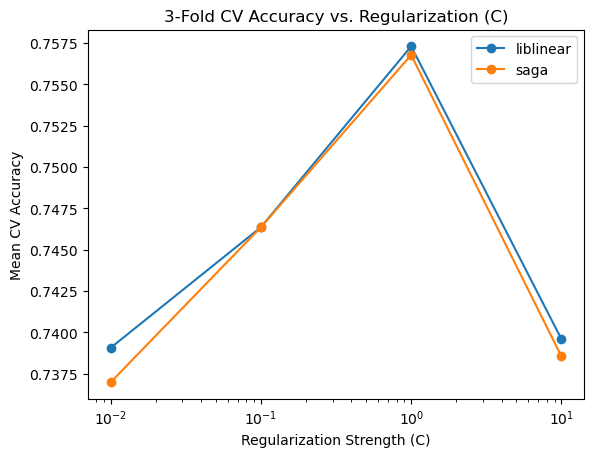


Example False Positives:
                                                 text
0   It only recognizes the Phone as its storage de...
1   Disappointing accessory from a good manufacturer.
9   The picture resolution is far below what other...
19                         It also had a new problem.
36  This phone tries very hard to do everything bu...

Example False Negatives:
                                                  text
102                              W810i is just SUPERB.
104  Cheap but hey it works.. Was pleasantly supris...
108  No shifting, no bubbling, no peeling, not even...
109  I was looking for this headset for a long time...
111                          The delivery was on time.

Final Test Performance: Accuracy=78.83%, Precision=82.64%, Recall=73.00%, F1=77.52%


In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Split the data into an 80% training subset and a 20% validation subset
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf,
    y_train['is_positive_sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=y_train['is_positive_sentiment']
)

# Hyperparameter tuning with 3-fold cross-validation
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_split, y_train_split)

# Best hyperparameters and CV score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
print(f"Best CV Score: {best_cv_score:.4f}")
print(f"Best Hyperparameters: {best_params}")

# Retrain final model on full training subset
final_model = grid_search.best_estimator_
final_model.fit(X_train_split, y_train_split)

# Evaluate on validation set
y_val_pred = final_model.predict(X_val_split)
print("\nValidation Set Evaluation:")
print(confusion_matrix(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# Evaluate on test set
y_test_pred = final_model.predict(X_test_tfidf)
print("\nTest Set Evaluation:")
print(confusion_matrix(y_test['is_positive_sentiment'], y_test_pred))
print(classification_report(y_test['is_positive_sentiment'], y_test_pred))

# Plot hyperparameter search results
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure()
for solver in cv_results['param_solver'].unique():
    subset = cv_results[cv_results['param_solver'] == solver]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=solver)
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean CV Accuracy')
plt.title('3-Fold CV Accuracy vs. Regularization (C)')
plt.legend()
plt.show()

# Display misclassifications examples
df_test = x_test.copy()
df_test['true'] = y_test['is_positive_sentiment']
df_test['pred'] = y_test_pred

print("\nExample False Positives:")
print(df_test[(df_test['true'] == 0) & (df_test['pred'] == 1)][['text']].head())

print("\nExample False Negatives:")
print(df_test[(df_test['true'] == 1) & (df_test['pred'] == 0)][['text']].head())

# Summary of final test performance
report = classification_report(y_test['is_positive_sentiment'], y_test_pred, output_dict=True)
accuracy = report['accuracy']
precision = report['1']['precision']
recall = report['1']['recall']
f1_score = report['1']['f1-score']
print(f"\nFinal Test Performance: Accuracy={accuracy:.2%}, Precision={precision:.2%}, Recall={recall:.2%}, F1={f1_score:.2%}")
